In [1]:
import tqdm
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from zeo_amd.plotting import savefig
from zeo_amd.cluster import get_positive_clusters, homogeneity_score, recall_homogeneity

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_soap.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

LABELS = ['Al', 'B', 'Be', 'Ca', 'Co', 'F', 'Ga', 'Ge', 'K', 'Mg', 'Na', 'P', 'Si', 'Zn']

In [3]:
Z = linkage(squareform(dm.values), method='ward')

## Quantifying degree of clustering

In [8]:
SYN_THRESHOLD = 0.25
THRESHOLDS = np.concatenate([
    np.arange(0.005, 0.01, 0.0002),
    np.arange(0.01, 0.1, 0.002),
    np.arange(0.1, 1, 0.01),
    np.arange(1, 3.5, 0.1),
])
    
results = []
for threshold in tqdm.tqdm(THRESHOLDS):
    clusters = fcluster(Z, threshold, criterion='distance')
    
    for condition in synth.columns:
        labels = (synth[condition] > SYN_THRESHOLD).astype(int)

        _l, _c = get_positive_clusters(labels.values, clusters)
        
        results.append({
            "threshold": threshold,
            condition: homogeneity_score(_l, _c)
        })

df = pd.DataFrame(results)
df = df.groupby("threshold").first()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:22<00:00,  8.17it/s]


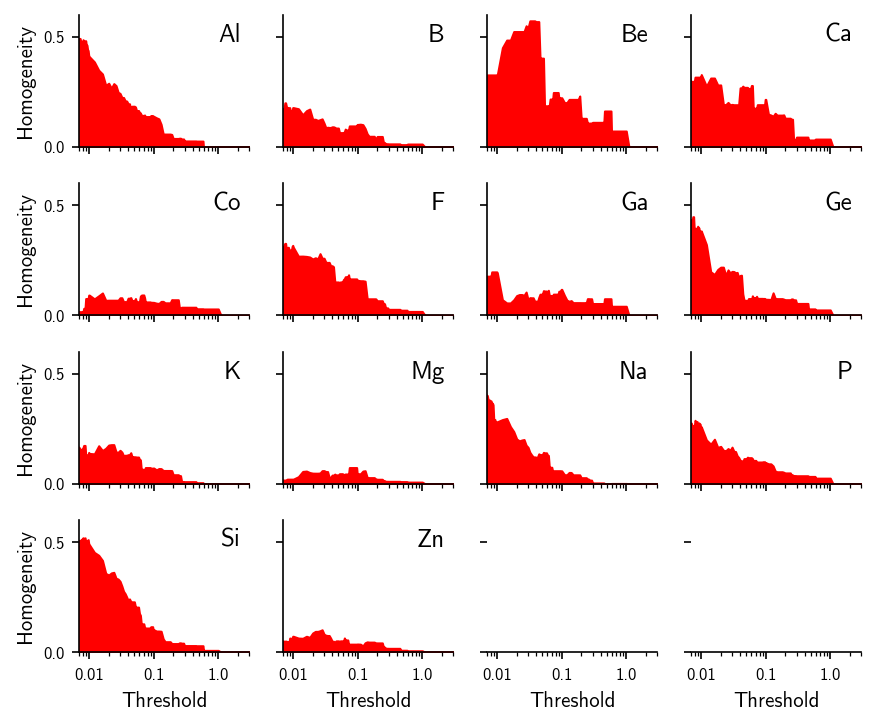

In [12]:
LX, LY = 1.5, 1.25
fig, ax_fig = plt.subplots(4, 4, figsize=(4 * LX, 4 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), LABELS):
    ax.fill_between(
        df.index,
        df[label],
        label=label,
        color="r",
    )
    ax.set_xlim(0.007, 3)
    ax.set_ylim(0, 0.6)
    ax.set_xscale("log")
    ax.annotate(label, (0.95, 0.85), xycoords='axes fraction', ha="right", va="center")
    ax.xaxis.set_tick_params(labelbottom=False)

for ax in ax_fig.reshape(-1)[-2:]:
#     ax.set_yticks([])
    ax.yaxis.set_tick_params(labelleft=False)
    ax.spines["left"].set_visible(False)

for ax in ax_fig[-1, :]:
    ax.set_xlabel("Threshold", fontsize=10)
    ax.set_xticks([0.01, 0.1, 1])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_xticklabels([0.01, 0.1, 1.0], fontsize=8)    

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Homogeneity", fontsize=10)
    ax.set_yticks([0.0, 0.5])
    ax.set_yticklabels([0.0, 0.5], fontsize=8)

fig.tight_layout()
# savefig(fig, "03-synthesis-homogeneity-soap.pdf")
plt.show()